# MongoDB Analytics - PA Recommender

## Setup

In [2]:
import sys
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from utils.mongodb_client import get_mongodb_client

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Connect to MongoDB
client = get_mongodb_client()
db = client.get_database()

print("Connected to MongoDB")
print(f"Collections: {client.list_collections()}")

Connected to MongoDB: pa_recommender
Connected to MongoDB
Collections: ['interactions', 'product_recommendations']


---

## 1. Broj interakcija po tipu akcije


=== Broj interakcija po tipu akcije ===
              Action   Count
0       content_view  814445
1        add_to_cart   22750
2  initiate_checkout    9748
3           purchase    3065
4    add_to_wishlist     682

Ukupno interakcija: 850,690


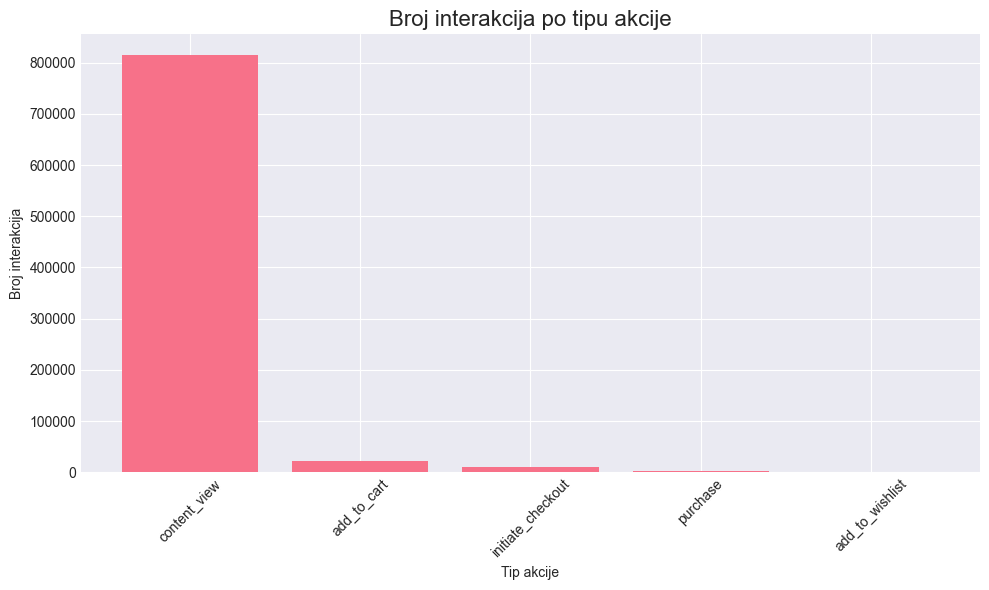


ANALIZA:
Najčešća akcija: content_view (814,445 puta)
  - content_view: 95.74%
  - add_to_cart: 2.67%
  - initiate_checkout: 1.15%
  - purchase: 0.36%
  - add_to_wishlist: 0.08%


In [ ]:
pipeline = [
    {
        "$group": {
            "_id": "$action", # grupisanje po polju action
            "count": {"$sum": 1} # broji koliko ima svake akcije
        }
    },
    {
        "$sort": {"count": -1} # opadajuce
    }
]

result = list(db.interactions.aggregate(pipeline))
df_actions = pd.DataFrame(result)
df_actions.columns = ['Action', 'Count']

print("\n=== Broj interakcija po tipu akcije ===")
print(df_actions)
print(f"\nUkupno interakcija: {df_actions['Count'].sum():,}")

# Vizualizacija
plt.figure(figsize=(10, 6))
plt.bar(df_actions['Action'], df_actions['Count'])
plt.title('Broj interakcija po tipu akcije', fontsize=16)
plt.xlabel('Tip akcije')
plt.ylabel('Broj interakcija')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
most_common = df_actions.iloc[0]
print(f"Najčešća akcija: {most_common['Action']} ({most_common['Count']:,} puta)")
total = df_actions['Count'].sum()
for _, row in df_actions.iterrows():
    percentage = (row['Count'] / total) * 100
    print(f"  - {row['Action']}: {percentage:.2f}%")

---

## 2. Top 20 najaktivnijih korisnika


=== Top 20 najaktivnijih korisnika ===
                                    user_uid  total_interactions  \
0   TWFpbjMyNGI1YlNhQTUzczIwMjU1MzAxNTQwMjc=                1347   
1   N0RSOWdsdDFqa2JDZmczWTIwMjUxMTE5MjEyNw==                1022   
2   Y2hwdE5hZmNUUUNnMXlidTIwMjUyMjYxNzQ3MTI=                1011   
3   T0lyNVpjOHduTjlSTVFwSzIwMjU0MTIyMzU1OA==                 995   
4       eXQ5a3hrNHVUaDNPbkltSTIwMjU4MTcxMjQx                 914   
5       SGFabzNmU1NoUlppSHBFaDIwMjUwMjM4NDE2                 883   
6   dDd2ZHJ4Tk1Bc0JUR0FBdjIwMjUyMTc3NTgyMg==                 739   
7   TXB6dERiVTROSlJhYUxUVDIwMjU2MTMyMzU1NA==                 732   
8   NmtQcUo3Uk16OTVVYjhORjIwMjU4MjkxNTI1NDc=                 709   
9   cml0ZjdQc3VQNGI3YTJLejIwMjUxMDE4MTU0MzEx                 673   
10  dmw2SFI2anJuemFTWXhhUjIwMjQxMTE2MTA3MTg=                 637   
11  enJKMjVvdGRxTUVwMjNSNTIwMjUxMDI0MjMyMzQ2                 625   
12  R0ZmYzJKUmxHQWE2eVYxSDIwMjU3OTIxMTkyNw==                 585   
13  eTl3

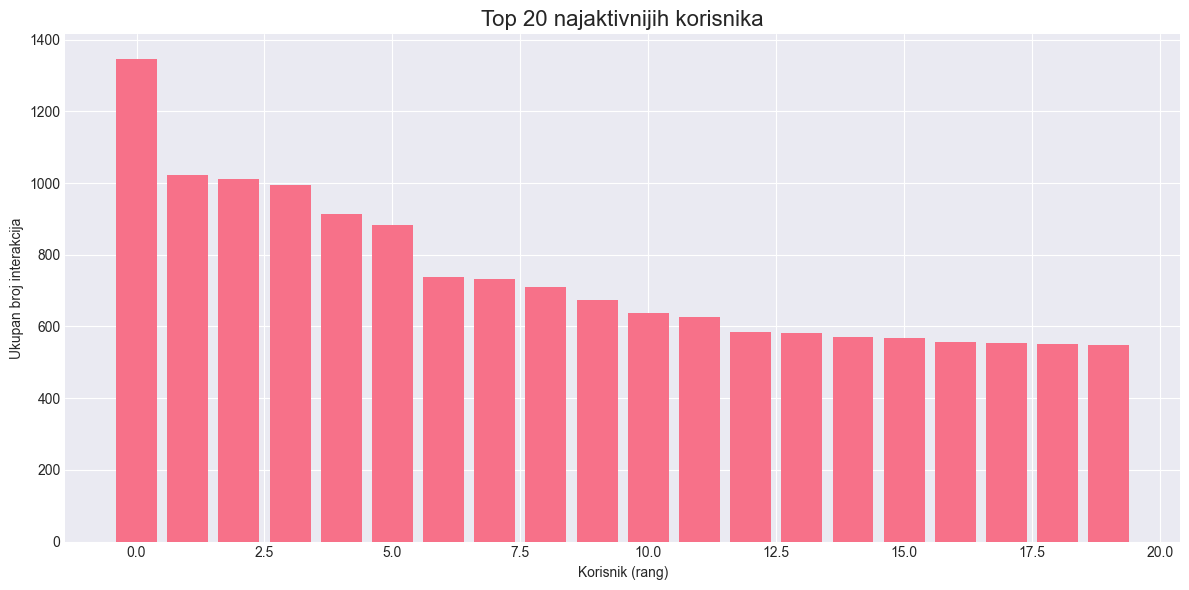


ANALIZA:
Najaktivniji korisnik ima 1347 interakcija
Prosečan broj interakcija top 20: 740.00
Prosečan broj jedinstvenih proizvoda: 381.45


In [ ]:
pipeline = [
    {
        "$group": {
            "_id": "$user_uid",
            "total_interactions": {"$sum": 1},
            "unique_products": {"$addToSet": "$product_id"}, # unique proizvodi na koje je reagovao
            # Za razliku od $addToSet (koji čuva samo jedinstvene vrednosti), $push čuva sve, uključujući duplikate.
            "actions": {"$push": "$action"} # uzimamo sve akcije
        }
    },
    {
        "$project": {
            "user_uid": "$_id",
            "total_interactions": 1,
            "unique_products_count": {"$size": "$unique_products"},
            "add_to_cart_count": {
                "$size": {
                    "$filter": {
                        "input": "$actions",
                        "as": "action",
                        "cond": {"$eq": ["$$action", "add_to_cart"]}
                    }
                }
            },
            "content_view_count": {
                "$size": {
                    "$filter": {
                        "input": "$actions",
                        "as": "action",
                        "cond": {"$eq": ["$$action", "content_view"]}
                    }
                }
            }
        }
    },
    {
        "$sort": {"total_interactions": -1}
    },
    {
        "$limit": 20
    }
]

result = list(db.interactions.aggregate(pipeline))
df_top_users = pd.DataFrame(result)

print("\n=== Top 20 najaktivnijih korisnika ===")
# iz ovoga mozemo da zakljucimo npr. da li je neko bot, ako ima previse view products a 0 ostalih interakcija - brisi ga
print(df_top_users[['user_uid', 'total_interactions', 'unique_products_count', 'add_to_cart_count', 'content_view_count']].head(20))

# Vizualizacija
plt.figure(figsize=(12, 6))
plt.bar(range(len(df_top_users)), df_top_users['total_interactions'])
plt.title('Top 20 najaktivnijih korisnika', fontsize=16)
plt.xlabel('Korisnik (rang)')
plt.ylabel('Ukupan broj interakcija')
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
print(f"Najaktivniji korisnik ima {df_top_users.iloc[0]['total_interactions']} interakcija")
print(f"Prosečan broj interakcija top 20: {df_top_users['total_interactions'].mean():.2f}")
print(f"Prosečan broj jedinstvenih proizvoda: {df_top_users['unique_products_count'].mean():.2f}")

---

## 3. Top 30 najpopularnijih proizvoda


=== Top 30 najpopularnijih proizvoda ===
    product_id  total_interactions  unique_users_count  add_to_cart  \
0      37447.0                5434                2353          809   
1      37457.0                2304                1361          200   
2      89965.0                2268                1299           43   
3      12873.0                2172                1368           63   
4      37274.0                2132                 959          440   
5       2190.0                1795                1400           11   
6      52450.0                1674                1345            0   
7       7931.0                1258                 733           75   
8      11361.0                1254                 525           81   
9      43025.0                1196                 699           29   
10     46081.0                1194                 755           61   
11     59978.0                1193                 814            6   
12     12131.0                1176 

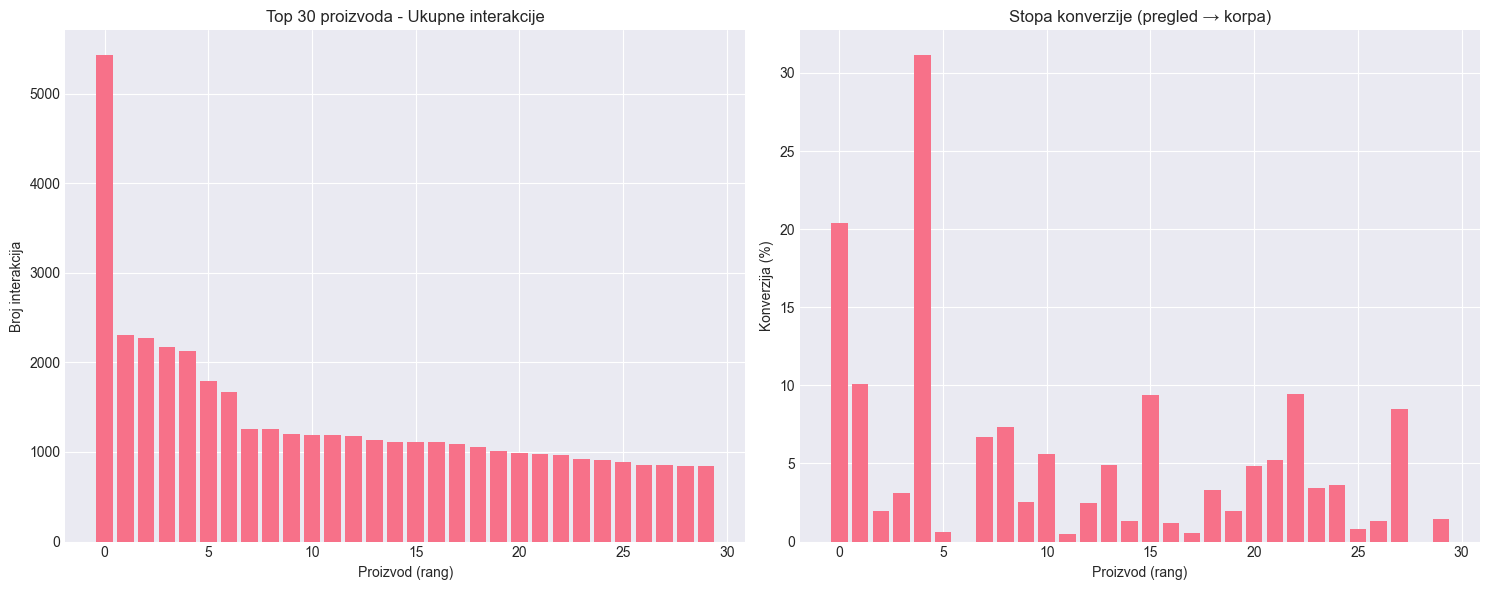


ANALIZA:
Najpopularniji proizvod ID: 37447.0
Prosečna stopa konverzije: 5.12%
Najbolja stopa konverzije: 31.16%


In [ ]:
pipeline = [
    {
        "$group": {
            "_id": "$product_id",
            "total_interactions": {"$sum": 1},
            "unique_users": {"$addToSet": "$user_uid"},
            "add_to_cart": {
                "$sum": {
                    "$cond": [{"$eq": ["$action", "add_to_cart"]}, 1, 0]
                }
            },
            "content_view": {
                "$sum": {
                    "$cond": [{"$eq": ["$action", "content_view"]}, 1, 0]
                }
            }
        }
    },
    {
        "$project": {
            "product_id": "$_id",
            "total_interactions": 1,
            "unique_users_count": {"$size": "$unique_users"},
            "add_to_cart": 1,
            "content_view": 1,
            # conversion rate ovde racunamo kao odnos dodavanja u korpu i pogledanog proizvoda, sto nije tacno
            "conversion_rate": {
                "$cond": [
                    {"$gt": ["$content_view", 0]},
                    {"$multiply": [{"$divide": ["$add_to_cart", "$content_view"]}, 100]},
                    0
                ]
            }
        }
    },
    {
        "$sort": {"total_interactions": -1}
    },
    {
        "$limit": 30
    }
]

result = list(db.interactions.aggregate(pipeline))
df_top_products = pd.DataFrame(result)

print("\n=== Top 30 najpopularnijih proizvoda ===")
print(df_top_products[['product_id', 'total_interactions', 'unique_users_count', 'add_to_cart', 'content_view', 'conversion_rate']].head(30))

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(range(len(df_top_products)), df_top_products['total_interactions'])
axes[0].set_title('Top 30 proizvoda - Ukupne interakcije')
axes[0].set_xlabel('Proizvod (rang)')
axes[0].set_ylabel('Broj interakcija')

axes[1].bar(range(len(df_top_products)), df_top_products['conversion_rate'])
axes[1].set_title('Stopa konverzije (pregled -> korpa)')
axes[1].set_xlabel('Proizvod (rang)')
axes[1].set_ylabel('Konverzija (%)')

plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
print(f"Najpopularniji proizvod ID: {df_top_products.iloc[0]['product_id']}")
print(f"Prosečna stopa konverzije: {df_top_products['conversion_rate'].mean():.2f}%")
print(f"Najbolja stopa konverzije: {df_top_products['conversion_rate'].max():.2f}%")

---

## 4. Dnevna distribucija interakcija


=== Distribucija interakcija po satima ===
    _id  total_interactions  add_to_cart  hour  unique_users_count
0     0               10855          386     0                4610
1     1                5941          148     1                2603
2     2                4009          134     2                1879
3     3                4842          127     3                2344
4     4                8623          220     4                4393
5     5               18646          423     5                9118
6     6               30496          668     6               14667
7     7               38182          992     7               18310
8     8               42069         1075     8               19821
9     9               44249         1247     9               21057
10   10               46050         1294    10               22134
11   11               46448         1310    11               22335
12   12               47141         1227    12               23571
13   13           

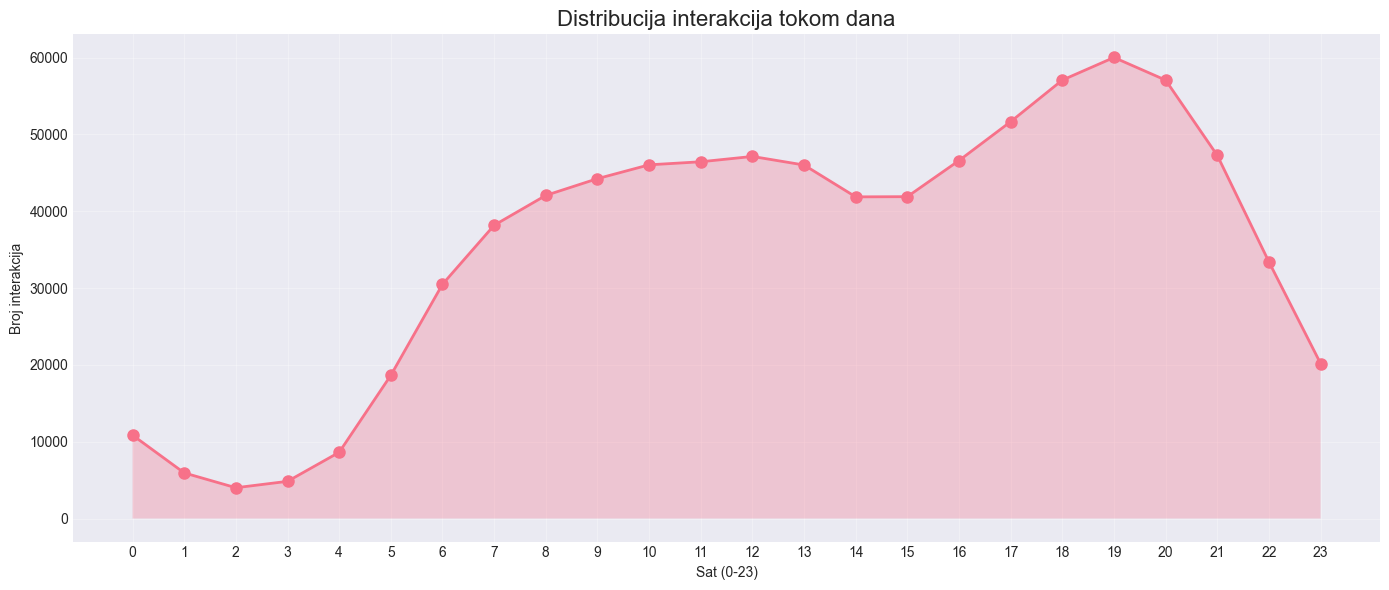


ANALIZA:
Najviše aktivnosti u 19h: 60,026 interakcija
Najmanje aktivnosti u 2h: 4,009 interakcija


In [ ]:
pipeline = [
    {
        "$group": {
            "_id": "$created_hour",
            "total_interactions": {"$sum": 1},
            "unique_users": {"$addToSet": "$user_uid"},
            "add_to_cart": {
                "$sum": {"$cond": [{"$eq": ["$action", "add_to_cart"]}, 1, 0]}
            }
        }
    },
    {
        "$project": {
            "hour": "$_id",
            "total_interactions": 1,
            "unique_users_count": {"$size": "$unique_users"},
            "add_to_cart": 1
        }
    },
    {
        "$sort": {"hour": 1}
    }
]

result = list(db.interactions.aggregate(pipeline))
df_hourly = pd.DataFrame(result)

print("\n=== Distribucija interakcija po satima ===")
print(df_hourly)

# Vizualizacija
plt.figure(figsize=(14, 6))
plt.plot(df_hourly['hour'], df_hourly['total_interactions'], marker='o', linewidth=2, markersize=8)
plt.fill_between(df_hourly['hour'], df_hourly['total_interactions'], alpha=0.3)
plt.title('Distribucija interakcija tokom dana', fontsize=16)
plt.xlabel('Sat (0-23)')
plt.ylabel('Broj interakcija')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
peak_hour = df_hourly.loc[df_hourly['total_interactions'].idxmax()]
print(f"Najviše aktivnosti u {int(peak_hour['hour'])}h: {peak_hour['total_interactions']:,} interakcija")
quiet_hour = df_hourly.loc[df_hourly['total_interactions'].idxmin()]
print(f"Najmanje aktivnosti u {int(quiet_hour['hour'])}h: {quiet_hour['total_interactions']:,} interakcija")

---

## 5. Nedeljna distribucija interakcija


=== Distribucija interakcija po danima ===
     day_name  total_interactions  unique_users_count  add_to_cart
0  Ponedeljak              129609               51461         3584
1      Utorak              116861               47723         3200
2       Sreda              126671               50308         3824
3    Četvrtak              125781               50952         3465
4       Petak              125743               53979         3007
5      Subota              109828               44135         2907
6     Nedelja              116197               46729         2763


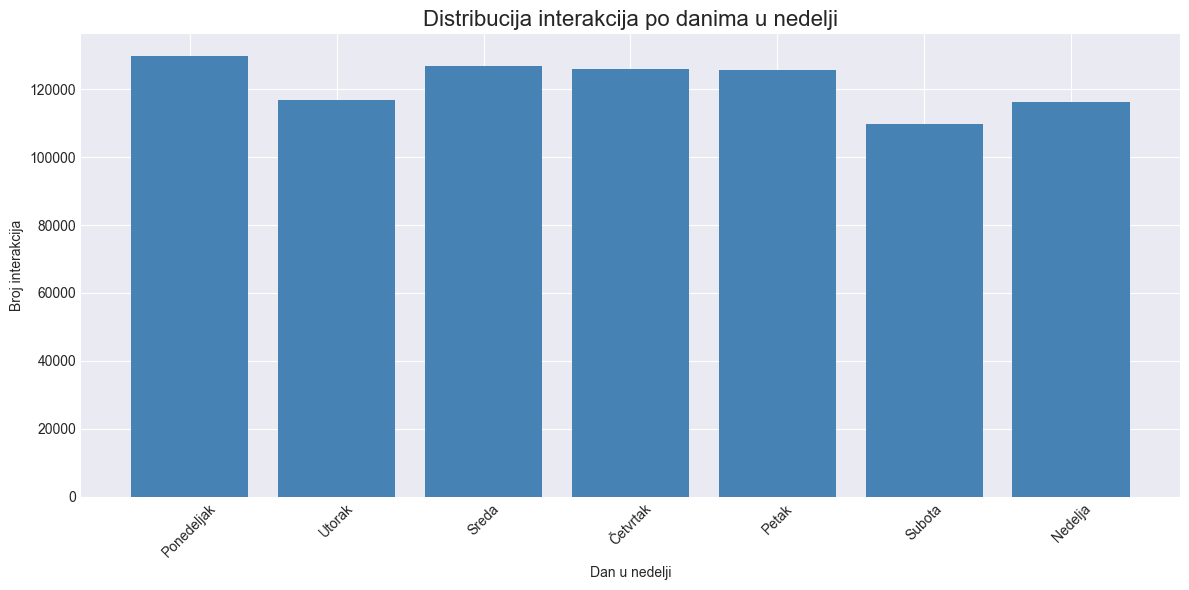


ANALIZA:
Najaktivniji dan: Ponedeljak (129,609 interakcija)
Najmanje aktivan dan: Subota (109,828 interakcija)


In [ ]:
# po ovome vidimo da dan nema velikog znacaja za kolicinu interakcija
pipeline = [
    {
        "$group": {
            "_id": "$created_day_of_week",
            "total_interactions": {"$sum": 1},
            "unique_users": {"$addToSet": "$user_uid"},
            "add_to_cart": {
                "$sum": {"$cond": [{"$eq": ["$action", "add_to_cart"]}, 1, 0]}
            }
        }
    },
    {
        "$project": {
            "day_of_week": "$_id",
            "total_interactions": 1,
            "unique_users_count": {"$size": "$unique_users"},
            "add_to_cart": 1
        }
    },
    {
        "$sort": {"day_of_week": 1}
    }
]

result = list(db.interactions.aggregate(pipeline))
df_weekly = pd.DataFrame(result)

# Mapiranje dana
day_names = ['Ponedeljak', 'Utorak', 'Sreda', 'Četvrtak', 'Petak', 'Subota', 'Nedelja']
df_weekly['day_name'] = df_weekly['day_of_week'].apply(lambda x: day_names[int(x)])

print("\n=== Distribucija interakcija po danima ===")
print(df_weekly[['day_name', 'total_interactions', 'unique_users_count', 'add_to_cart']])

# Vizualizacija
plt.figure(figsize=(12, 6))
plt.bar(df_weekly['day_name'], df_weekly['total_interactions'], color='steelblue')
plt.title('Distribucija interakcija po danima u nedelji', fontsize=16)
plt.xlabel('Dan u nedelji')
plt.ylabel('Broj interakcija')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
busiest_day = df_weekly.loc[df_weekly['total_interactions'].idxmax()]
print(f"Najaktivniji dan: {busiest_day['day_name']} ({busiest_day['total_interactions']:,} interakcija)")
slowest_day = df_weekly.loc[df_weekly['total_interactions'].idxmin()]
print(f"Najmanje aktivan dan: {slowest_day['day_name']} ({slowest_day['total_interactions']:,} interakcija)")

---

## 6. Konverziona funel analiza


=== Konverziona Funel Analiza ===
Ukupno korisnika: 253,345
Korisnici sa pregledima: 252,739
Korisnici sa korpicom: 8,638
Korisnici sa oba: 8,035

Stopa pregleda: 99.76%
Stopa dodavanja u korpu: 3.41%
Konverzija (pregled -> korpa): 3.18%


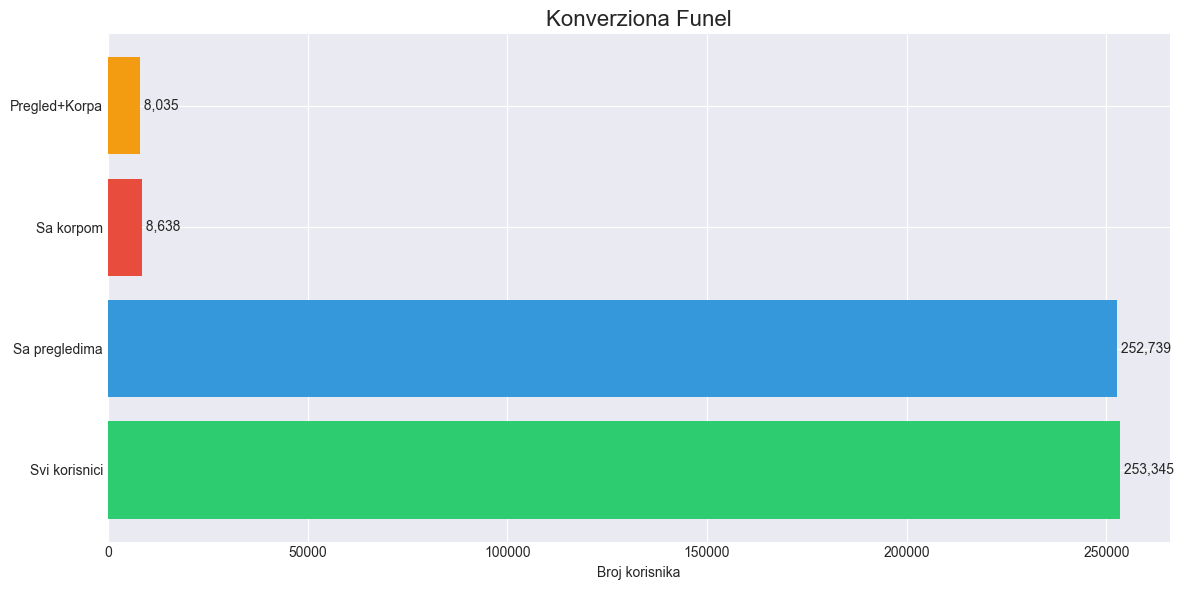


ANALIZA:
Od 100 korisnika, 100 pregleda proizvode
Od tih 100, 3 dodaje proizvode u korpu


In [ ]:
# ocekivano da vecina korisnika prvo klikne na proizvod pa doda u korpu
pipeline = [
    {
        "$group": {
            "_id": "$user_uid",
            "has_content_view": {
                "$max": {"$cond": [{"$eq": ["$action", "content_view"]}, 1, 0]}
            },
            "has_add_to_cart": {
                "$max": {"$cond": [{"$eq": ["$action", "add_to_cart"]}, 1, 0]}
            }
        }
    },
    {
        "$group": {
            "_id": None,
            "total_users": {"$sum": 1},
            "users_with_view": {"$sum": "$has_content_view"},
            "users_with_cart": {"$sum": "$has_add_to_cart"},
            "users_with_both": {
                "$sum": {
                    "$cond": [
                        {"$and": [
                            {"$eq": ["$has_content_view", 1]},
                            {"$eq": ["$has_add_to_cart", 1]}
                        ]},
                        1,
                        0
                    ]
                }
            }
        }
    }
]

result = list(db.interactions.aggregate(pipeline))
funnel_data = result[0]

print("\n=== Konverziona Funel Analiza ===")
print(f"Ukupno korisnika: {funnel_data['total_users']:,}")
print(f"Korisnici sa pregledima: {funnel_data['users_with_view']:,}")
print(f"Korisnici sa korpicom: {funnel_data['users_with_cart']:,}")
print(f"Korisnici sa oba: {funnel_data['users_with_both']:,}")

# Izračunavanje konverzija
view_rate = (funnel_data['users_with_view'] / funnel_data['total_users']) * 100
cart_rate = (funnel_data['users_with_cart'] / funnel_data['total_users']) * 100
conversion_rate = (funnel_data['users_with_both'] / funnel_data['users_with_view']) * 100 if funnel_data['users_with_view'] > 0 else 0

print(f"\nStopa pregleda: {view_rate:.2f}%")
print(f"Stopa dodavanja u korpu: {cart_rate:.2f}%")
print(f"Konverzija (pregled -> korpa): {conversion_rate:.2f}%")

# Vizualizacija
stages = ['Svi korisnici', 'Sa pregledima', 'Sa korpom', 'Pregled+Korpa']
values = [funnel_data['total_users'], funnel_data['users_with_view'], 
          funnel_data['users_with_cart'], funnel_data['users_with_both']]

plt.figure(figsize=(12, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
plt.barh(stages, values, color=colors)
plt.title('Konverziona Funel', fontsize=16)
plt.xlabel('Broj korisnika')
for i, v in enumerate(values):
    plt.text(v, i, f' {v:,}', va='center')
plt.tight_layout()
plt.show()

print("\nANALIZA:")
print(f"Od 100 korisnika, {view_rate:.0f} pregleda proizvode")
print(f"Od tih {view_rate:.0f}, {conversion_rate:.0f} dodaje proizvode u korpu")

---

## 7. Prosečan broj interakcija po korisniku po danu

In [9]:
pipeline = [
    {
        "$group": {
            "_id": {
                "user": "$user_uid",
                "date": "$created_date"
            },
            "daily_interactions": {"$sum": 1}
        }
    },
    {
        "$group": {
            "_id": None,
            "avg_daily_interactions": {"$avg": "$daily_interactions"},
            "max_daily_interactions": {"$max": "$daily_interactions"},
            "min_daily_interactions": {"$min": "$daily_interactions"},
            "total_user_days": {"$sum": 1}
        }
    }
]

result = list(db.interactions.aggregate(pipeline))
daily_stats = result[0]

print("\n=== Prosečne dnevne interakcije po korisniku ===")
print(f"Prosečno interakcija po danu: {daily_stats['avg_daily_interactions']:.2f}")
print(f"Maksimum interakcija po danu: {daily_stats['max_daily_interactions']}")
print(f"Minimum interakcija po danu: {daily_stats['min_daily_interactions']}")
print(f"Ukupno korisnik-dana: {daily_stats['total_user_days']:,}")

print("\nANALIZA:")
print(f"Prosečan korisnik napravi {daily_stats['avg_daily_interactions']:.0f} interakcije dnevno")
print(f"Najaktivniji korisnik napravio {daily_stats['max_daily_interactions']} interakcije u jednom danu")


=== Prosečne dnevne interakcije po korisniku ===
Prosečno interakcija po danu: 2.17
Maksimum interakcija po danu: 371
Minimum interakcija po danu: 1
Ukupno korisnik-dana: 391,370

ANALIZA:
Prosečan korisnik napravi 2 interakcije dnevno
Najaktivniji korisnik napravio 371 interakcije u jednom danu


---

## 8. Distribucija korisnika po broju interakcija (segmentacija)


=== Segmentacija korisnika po aktivnosti ===
                     label  user_count
0          1-4 (Neaktivni)      217637
1      5-9 (Slabo aktivni)       20926
2  10-19 (Umereno aktivni)        9176
3          20-49 (Aktivni)        4287
4    50-99 (Veoma aktivni)         919
5  100-499 (Super aktivni)         377
6   500+ (Power korisnici)          23


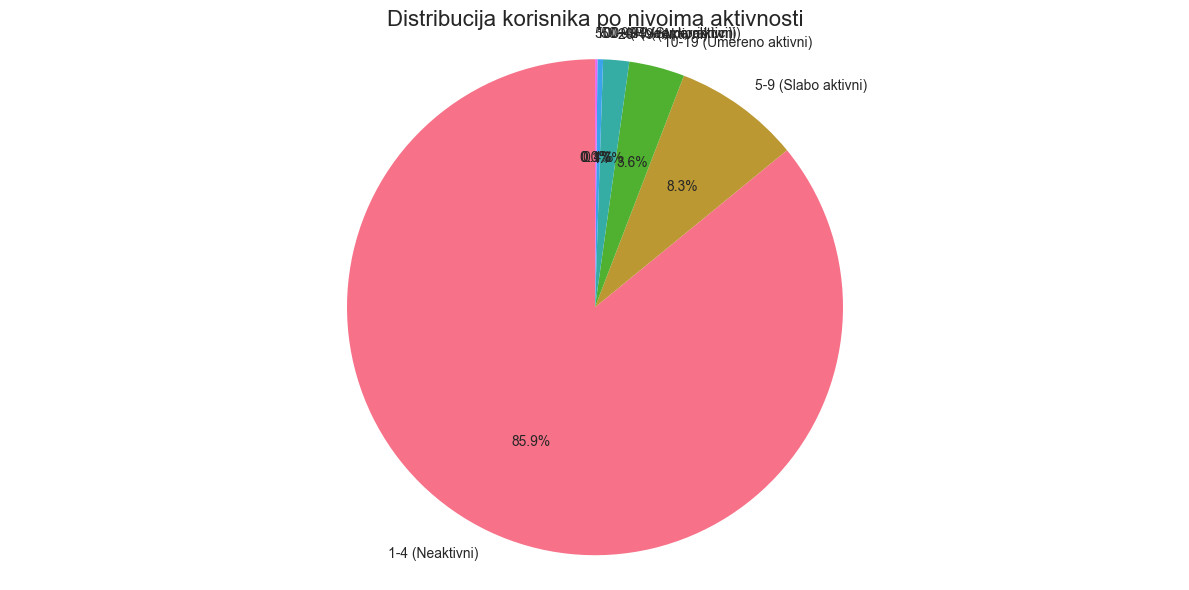


ANALIZA:
1-4 (Neaktivni): 217637 korisnika (85.91%)
5-9 (Slabo aktivni): 20926 korisnika (8.26%)
10-19 (Umereno aktivni): 9176 korisnika (3.62%)
20-49 (Aktivni): 4287 korisnika (1.69%)
50-99 (Veoma aktivni): 919 korisnika (0.36%)
100-499 (Super aktivni): 377 korisnika (0.15%)
500+ (Power korisnici): 23 korisnika (0.01%)


In [10]:
pipeline = [
    {
        "$group": {
            "_id": "$user_uid",
            "total_interactions": {"$sum": 1}
        }
    },
    {
        "$bucket": {
            "groupBy": "$total_interactions",
            "boundaries": [1, 5, 10, 20, 50, 100, 500, 10000],
            "default": "10000+",
            "output": {
                "count": {"$sum": 1},
                "users": {"$push": "$_id"}
            }
        }
    }
]

result = list(db.interactions.aggregate(pipeline))
df_segments = pd.DataFrame(result)
df_segments['segment'] = df_segments['_id'].astype(str)
df_segments['user_count'] = df_segments['count']

# Kreiranje labela
segment_labels = {
    '1': '1-4 (Neaktivni)',
    '5': '5-9 (Slabo aktivni)',
    '10': '10-19 (Umereno aktivni)',
    '20': '20-49 (Aktivni)',
    '50': '50-99 (Veoma aktivni)',
    '100': '100-499 (Super aktivni)',
    '500': '500+ (Power korisnici)'
}
df_segments['label'] = df_segments['segment'].map(segment_labels)

print("\n=== Segmentacija korisnika po aktivnosti ===")
print(df_segments[['label', 'user_count']])

# Vizualizacija
plt.figure(figsize=(12, 6))
plt.pie(df_segments['user_count'], labels=df_segments['label'], autopct='%1.1f%%', startangle=90)
plt.title('Distribucija korisnika po nivoima aktivnosti', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
total_users = df_segments['user_count'].sum()
for _, row in df_segments.iterrows():
    percentage = (row['user_count'] / total_users) * 100
    print(f"{row['label']}: {row['user_count']} korisnika ({percentage:.2f}%)")

---

## 9. Proizvodi sa najboljom konverzijom


=== Top 20 proizvoda sa najboljom konverzijom ===
    product_id  views  cart_adds  conversion_rate
0      45047.0     13         23       176.923077
1      43671.0     11         19       172.727273
2       6622.0     15         24       160.000000
3      14194.0     14         21       150.000000
4      42829.0     17         21       123.529412
5      44518.0     21         25       119.047619
6      48394.0     11         12       109.090909
7      77385.0     11         10        90.909091
8      45048.0     25         22        88.000000
9      60205.0     22         19        86.363636
10     18465.0     14         12        85.714286
11     46529.0     10          7        70.000000
12     96843.0     10          7        70.000000
13      5676.0     21         14        66.666667
14     60198.0     12          8        66.666667
15     83725.0     11          7        63.636364
16      6892.0     11          7        63.636364
17     43070.0     21         13        61.904762

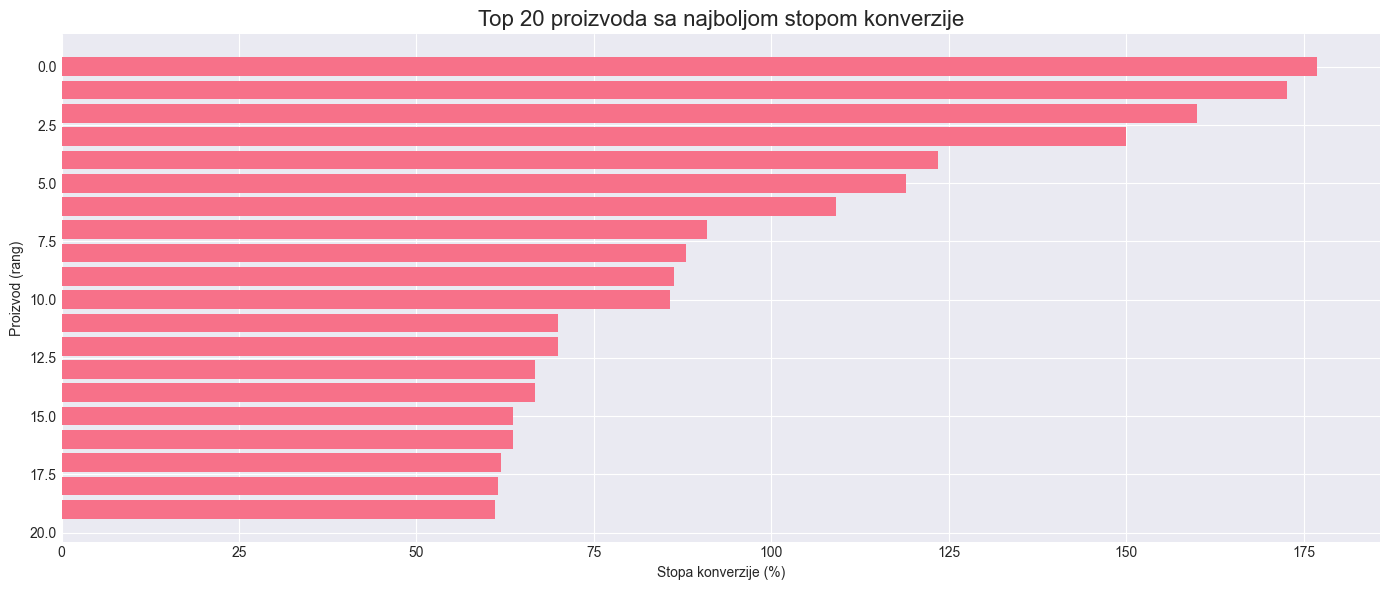


ANALIZA:
Najbolja konverzija: 176.92%
Prosečna konverzija top 20: 97.37%


In [11]:
pipeline = [
    {
        "$group": {
            "_id": "$product_id",
            "views": {
                "$sum": {"$cond": [{"$eq": ["$action", "content_view"]}, 1, 0]}
            },
            "cart_adds": {
                "$sum": {"$cond": [{"$eq": ["$action", "add_to_cart"]}, 1, 0]}
            }
        }
    },
    {
        "$match": {
            "views": {"$gte": 10}  # Najmanje 10 pregleda
        }
    },
    {
        "$project": {
            "product_id": "$_id",
            "views": 1,
            "cart_adds": 1,
            "conversion_rate": {
                "$multiply": [
                    {"$divide": ["$cart_adds", "$views"]},
                    100
                ]
            }
        }
    },
    {
        "$sort": {"conversion_rate": -1}
    },
    {
        "$limit": 20
    }
]

result = list(db.interactions.aggregate(pipeline))
df_best_conversion = pd.DataFrame(result)

print("\n=== Top 20 proizvoda sa najboljom konverzijom ===")
print(df_best_conversion[['product_id', 'views', 'cart_adds', 'conversion_rate']])

# Vizualizacija
plt.figure(figsize=(14, 6))
plt.barh(range(len(df_best_conversion)), df_best_conversion['conversion_rate'])
plt.title('Top 20 proizvoda sa najboljom stopom konverzije', fontsize=16)
plt.xlabel('Stopa konverzije (%)')
plt.ylabel('Proizvod (rang)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
print(f"Najbolja konverzija: {df_best_conversion.iloc[0]['conversion_rate']:.2f}%")
print(f"Prosečna konverzija top 20: {df_best_conversion['conversion_rate'].mean():.2f}%")

---

## 10. Mesečna analiza interakcija


=== Mesečna analiza interakcija ===
  month_name  total_interactions  unique_users_count  unique_products_count  \
0  Septembar              110786               40585                  19436   
1    Oktobar              234874               82050                  27373   
2   Novembar              285060              100203                  32963   
3   Decembar              219970               69509                  26581   

   add_to_cart  
0         2729  
1         6228  
2         7651  
3         6142  


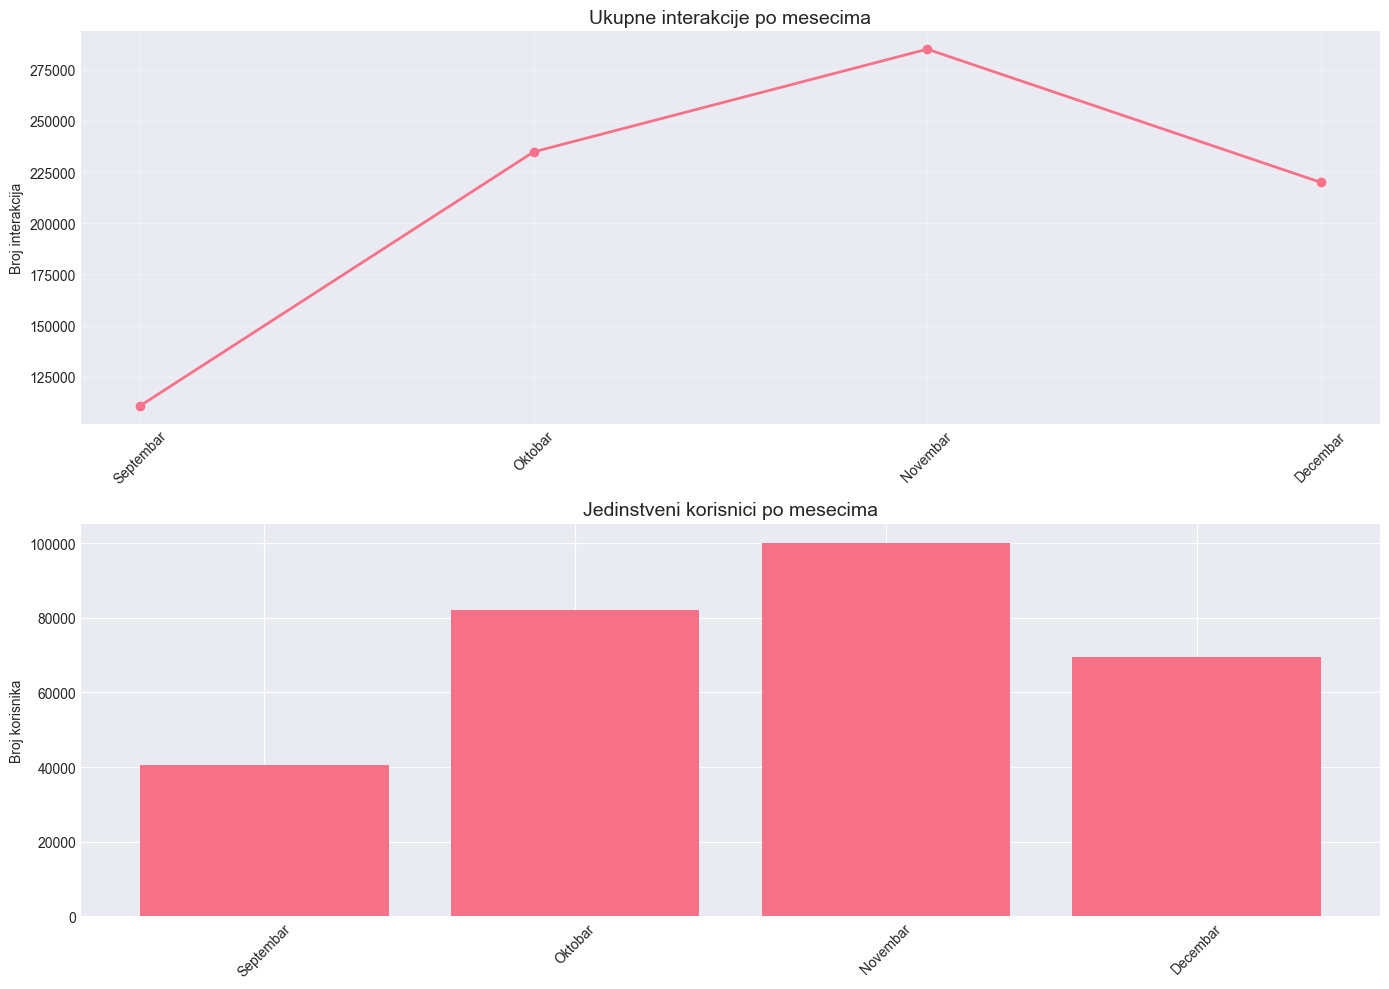


ANALIZA:
Najaktivniji mesec: Novembar (285,060 interakcija)


In [12]:
pipeline = [
    {
        "$group": {
            "_id": "$created_month",
            "total_interactions": {"$sum": 1},
            "unique_users": {"$addToSet": "$user_uid"},
            "unique_products": {"$addToSet": "$product_id"},
            "add_to_cart": {
                "$sum": {"$cond": [{"$eq": ["$action", "add_to_cart"]}, 1, 0]}
            }
        }
    },
    {
        "$project": {
            "month": "$_id",
            "total_interactions": 1,
            "unique_users_count": {"$size": "$unique_users"},
            "unique_products_count": {"$size": "$unique_products"},
            "add_to_cart": 1
        }
    },
    {
        "$sort": {"month": 1}
    }
]

result = list(db.interactions.aggregate(pipeline))
df_monthly = pd.DataFrame(result)

month_names = ['Januar', 'Februar', 'Mart', 'April', 'Maj', 'Jun', 
               'Jul', 'Avgust', 'Septembar', 'Oktobar', 'Novembar', 'Decembar']
df_monthly['month_name'] = df_monthly['month'].apply(lambda x: month_names[int(x)-1])

print("\n=== Mesečna analiza interakcija ===")
print(df_monthly[['month_name', 'total_interactions', 'unique_users_count', 'unique_products_count', 'add_to_cart']])

# Vizualizacija
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(df_monthly['month_name'], df_monthly['total_interactions'], marker='o', linewidth=2)
axes[0].set_title('Ukupne interakcije po mesecima', fontsize=14)
axes[0].set_ylabel('Broj interakcija')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(df_monthly['month_name'], df_monthly['unique_users_count'])
axes[1].set_title('Jedinstveni korisnici po mesecima', fontsize=14)
axes[1].set_ylabel('Broj korisnika')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
best_month = df_monthly.loc[df_monthly['total_interactions'].idxmax()]
print(f"Najaktivniji mesec: {best_month['month_name']} ({best_month['total_interactions']:,} interakcija)")

---

## 11. Co-occurrence analiza proizvoda

In [13]:
pipeline = [
    {
        "$match": {
            "action": "add_to_cart"
        }
    },
    {
        "$group": {
            "_id": "$user_uid",
            "products": {"$addToSet": "$product_id"}
        }
    },
    {
        "$match": {
            "products.1": {"$exists": True}  # Najmanje 2 proizvoda
        }
    },
    {
        "$project": {
            "user": "$_id",
            "product_count": {"$size": "$products"},
            "products": 1
        }
    },
    {
        "$group": {
            "_id": None,
            "avg_products_per_user": {"$avg": "$product_count"},
            "max_products_per_user": {"$max": "$product_count"},
            "users_with_multiple": {"$sum": 1}
        }
    }
]

result = list(db.interactions.aggregate(pipeline))
cooccurrence = result[0] if result else {}

print("\n=== Co-occurrence Analiza ===")
print(f"Korisnici sa više proizvoda u korpi: {cooccurrence.get('users_with_multiple', 0):,}")
print(f"Prosečan broj proizvoda po korisniku: {cooccurrence.get('avg_products_per_user', 0):.2f}")
print(f"Maksimum proizvoda u jednoj korpi: {cooccurrence.get('max_products_per_user', 0)}")

print("\nANALIZA:")
print("Korisnici često dodaju više proizvoda u korpu što pokazuje potencijal za cross-sell")


=== Co-occurrence Analiza ===
Korisnici sa više proizvoda u korpi: 2,341
Prosečan broj proizvoda po korisniku: 4.78
Maksimum proizvoda u jednoj korpi: 268

ANALIZA:
Korisnici često dodaju više proizvoda u korpu što pokazuje potencijal za cross-sell


---

## 12. Analiza retention-a korisnika


=== Analiza Retention-a (broj aktivnih dana) ===
     label   count
0   1 dana  200776
1   2 dana   42839
2   5 dana    7336
3  10 dana    1927
4  20 dana     436
5  50 dana      31


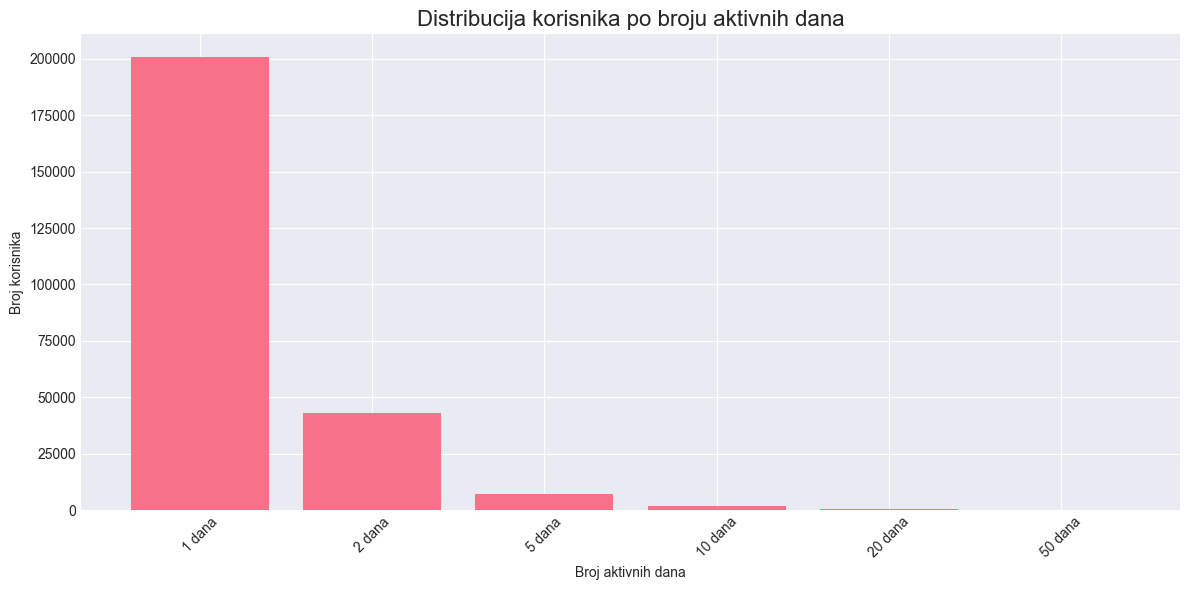


ANALIZA:
Stopa vraćanja: 20.75% korisnika se vraća


In [14]:
pipeline = [
    {
        "$group": {
            "_id": "$user_uid",
            "unique_dates": {"$addToSet": "$created_date"},
            "total_interactions": {"$sum": 1},
            "first_interaction": {"$min": "$created"},
            "last_interaction": {"$max": "$created"}
        }
    },
    {
        "$project": {
            "user": "$_id",
            "active_days": {"$size": "$unique_dates"},
            "total_interactions": 1,
            "days_active": {
                "$divide": [
                    {"$subtract": ["$last_interaction", "$first_interaction"]},
                    86400  # seconds in a day
                ]
            }
        }
    },
    {
        "$bucket": {
            "groupBy": "$active_days",
            "boundaries": [1, 2, 5, 10, 20, 50, 1000],
            "default": "50+",
            "output": {
                "count": {"$sum": 1}
            }
        }
    }
]

result = list(db.interactions.aggregate(pipeline))
df_retention = pd.DataFrame(result)
df_retention['label'] = df_retention['_id'].astype(str) + ' dana'

print("\n=== Analiza Retention-a (broj aktivnih dana) ===")
print(df_retention[['label', 'count']])

# Vizualizacija
plt.figure(figsize=(12, 6))
plt.bar(df_retention['label'], df_retention['count'])
plt.title('Distribucija korisnika po broju aktivnih dana', fontsize=16)
plt.xlabel('Broj aktivnih dana')
plt.ylabel('Broj korisnika')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
total_users = df_retention['count'].sum()
returning = df_retention[df_retention['_id'] != 1]['count'].sum()
retention_rate = (returning / total_users) * 100
print(f"Stopa vraćanja: {retention_rate:.2f}% korisnika se vraća")

---

## 13. Analiza efikasnosti preporuka


=== Analiza Efikasnosti Preporuka ===
Top 20 proizvoda sa najviše preporuka:
    product_id  total_recommendations  avg_weight  max_weight  min_weight
0        89965                   2001    0.479222  126.157686    0.099010
1        16629                   1127    0.627256  183.744108    0.099014
2        37447                   1017    1.829262  844.172013    0.099211
3        43035                    989    1.017459  294.654274    0.099009
4        89238                    936    0.377350   24.492686    0.099139
5        30887                    928    0.478911  103.684169    0.099073
6        91642                    897    0.561438   87.689764    0.099090
7        91725                    809    0.269793   10.199545    0.099026
8         2978                    784    0.676603   60.896481    0.099033
9        46081                    768    0.834337  185.990955    0.099040
10       37457                    745    1.035592  239.783506    0.099263
11        7928                    

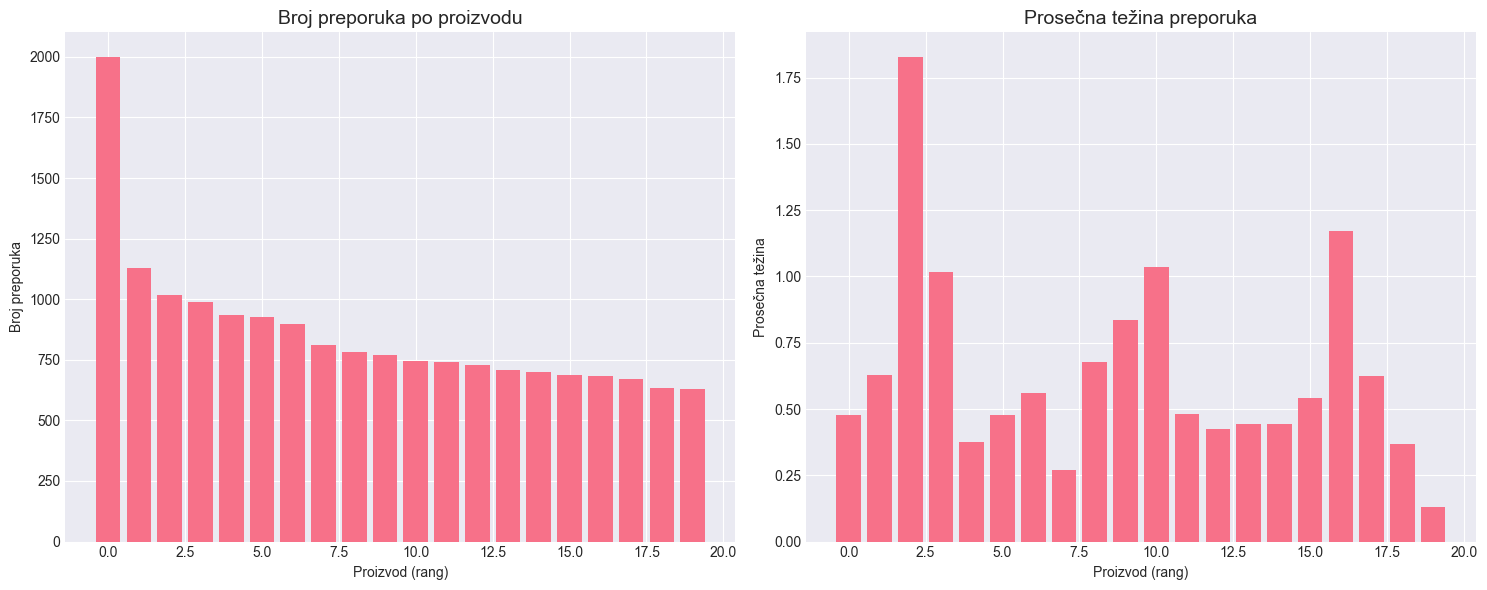


ANALIZA:
Proizvod sa najviše preporuka: ID 89965.0
Prosečna težina preporuka: 0.6405


In [15]:
pipeline = [
    {
        "$group": {
            "_id": "$product_to_recommend_id",
            "total_recommendations": {"$sum": 1},
            "avg_weight": {"$avg": "$interaction_weight"},
            "max_weight": {"$max": "$interaction_weight"},
            "min_weight": {"$min": "$interaction_weight"}
        }
    },
    {
        "$sort": {"total_recommendations": -1}
    },
    {
        "$limit": 20
    }
]

result = list(db.product_recommendations.aggregate(pipeline))
df_rec_analysis = pd.DataFrame(result)
df_rec_analysis.columns = ['product_id', 'total_recommendations', 'avg_weight', 'max_weight', 'min_weight']

print("\n=== Analiza Efikasnosti Preporuka ===")
print("Top 20 proizvoda sa najviše preporuka:")
print(df_rec_analysis)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(range(len(df_rec_analysis)), df_rec_analysis['total_recommendations'])
axes[0].set_title('Broj preporuka po proizvodu', fontsize=14)
axes[0].set_xlabel('Proizvod (rang)')
axes[0].set_ylabel('Broj preporuka')

axes[1].bar(range(len(df_rec_analysis)), df_rec_analysis['avg_weight'])
axes[1].set_title('Prosečna težina preporuka', fontsize=14)
axes[1].set_xlabel('Proizvod (rang)')
axes[1].set_ylabel('Prosečna težina')

plt.tight_layout()
plt.show()

# Analiza
print("\nANALIZA:")
print(f"Proizvod sa najviše preporuka: ID {df_rec_analysis.iloc[0]['product_id']}")
print(f"Prosečna težina preporuka: {df_rec_analysis['avg_weight'].mean():.4f}")

---

## 14. Distribucija težina preporuka


=== Distribucija Težina Preporuka ===
   range   count  avg_weight
0      0  819852    0.099939
1    0.1  255892    0.267929
2    0.5   46663    0.726933
3    1.0   23316    1.449259
4    2.0   13722    3.052243
5    5.0    5859   12.485846
6  Other      75  253.328133


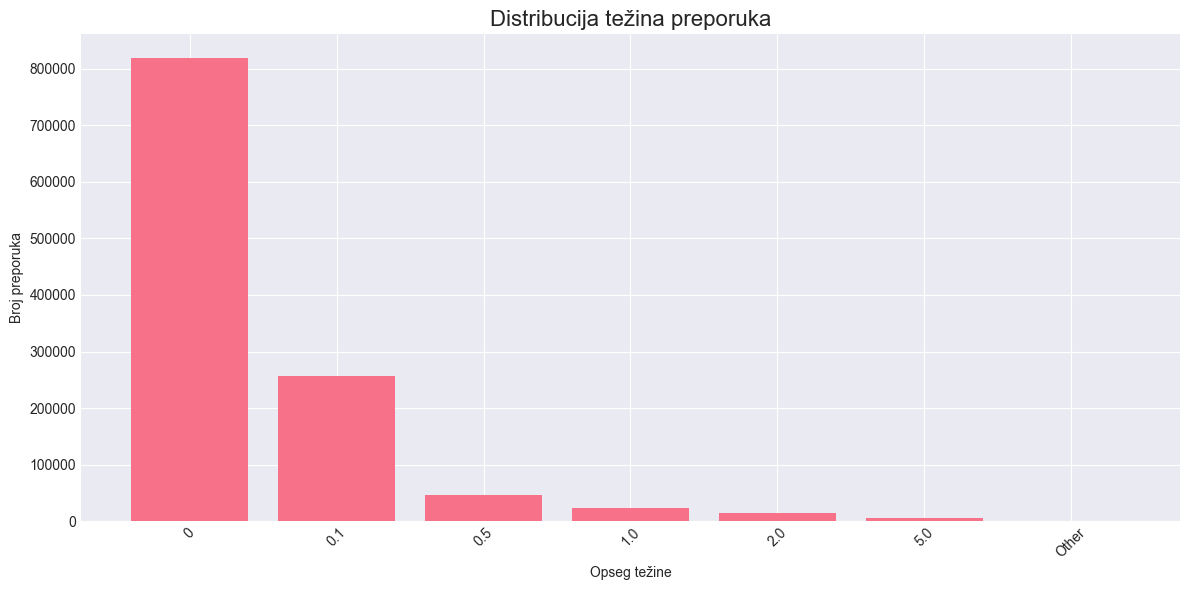


ANALIZA:
Ukupno preporuka: 1,165,379
Prosečna težina: 0.3023
Maksimalna težina: 2314.2460
Minimalna težina: 0.0990


In [17]:
pipeline = [
    {
        "$bucket": {
            "groupBy": "$interaction_weight",
            "boundaries": [0, 0.1, 0.5, 1.0, 2.0, 5.0, 100.0],
            "default": "Other",
            "output": {
                "count": {"$sum": 1},
                "avg_weight": {"$avg": "$interaction_weight"}
            }
        }
    }
]

result = list(db.product_recommendations.aggregate(pipeline))
df_weight_dist = pd.DataFrame(result)
df_weight_dist['range'] = df_weight_dist['_id'].astype(str)

print("\n=== Distribucija Težina Preporuka ===")
print(df_weight_dist[['range', 'count', 'avg_weight']])

# Vizualizacija
plt.figure(figsize=(12, 6))
plt.bar(df_weight_dist['range'], df_weight_dist['count'])
plt.title('Distribucija težina preporuka', fontsize=16)
plt.xlabel('Opseg težine')
plt.ylabel('Broj preporuka')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Dodatna statistika
pipeline_stats = [
    {
        "$group": {
            "_id": None,
            "total_recommendations": {"$sum": 1},
            "avg_weight": {"$avg": "$interaction_weight"},
            "max_weight": {"$max": "$interaction_weight"},
            "min_weight": {"$min": "$interaction_weight"}
        }
    }
]

stats = list(db.product_recommendations.aggregate(pipeline_stats))[0]

print("\nANALIZA:")
print(f"Ukupno preporuka: {stats['total_recommendations']:,}")
print(f"Prosečna težina: {stats['avg_weight']:.4f}")
print(f"Maksimalna težina: {stats['max_weight']:.4f}")
print(f"Minimalna težina: {stats['min_weight']:.4f}")

---

## 15. Proizvodi sa najviše različitih preporuka


=== Top 20 Proizvoda koji se Najčešće Preporučuju ===
    product_id  recommended_by_count  total_weight  avg_weight
0        89965                  1626    655.271048    0.402996
1        16629                  1029    705.202224    0.685328
2        37447                   897   2455.354291    2.737296
3        91642                   862    557.326638    0.646551
4        43035                   749    867.769413    1.158571
5        89972                   693    300.488880    0.433606
6        89238                   679    223.019073    0.328452
7        43025                   659    322.385365    0.489204
8        83680                   646    209.331648    0.324043
9        54258                   627    208.722855    0.332891
10       50028                   626    309.667374    0.494676
11       90005                   604    296.265504    0.490506
12        2978                   591    343.318711    0.580912
13       37457                   588    657.148396    1.117599


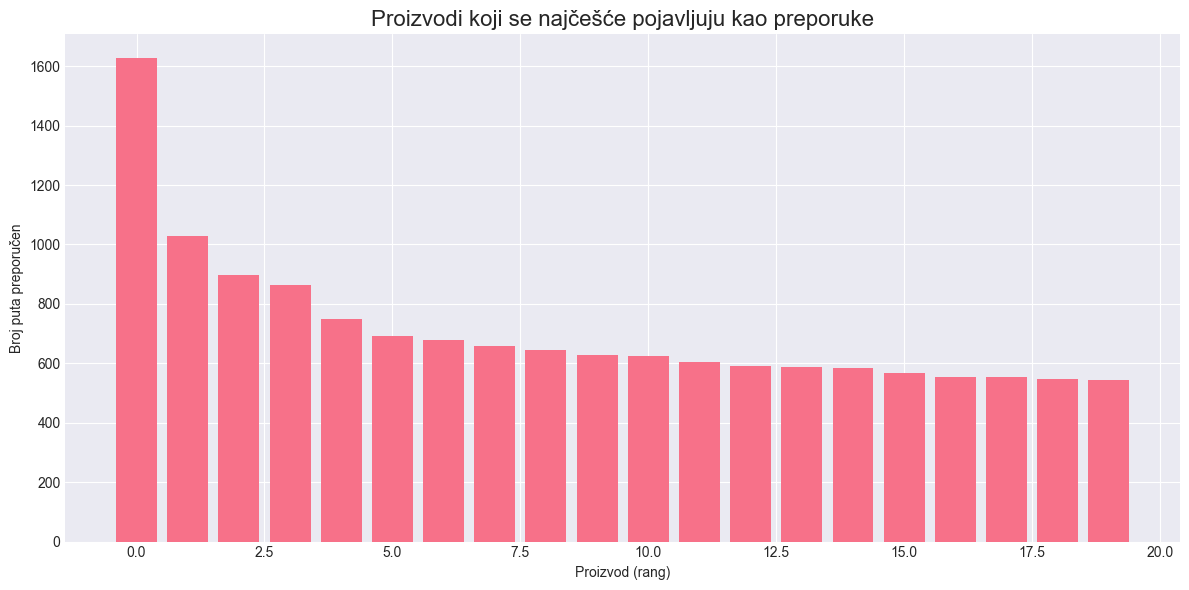


ANALIZA:
Najčešće preporučivan proizvod: ID 89965
Preporučen 1626.0 puta
Prosečna težina preporuke: 0.4030


In [18]:
pipeline = [
    {
        "$group": {
            "_id": "$product_for_recommendation_id",
            "recommended_by_count": {"$sum": 1},
            "total_weight": {"$sum": "$interaction_weight"},
            "avg_weight": {"$avg": "$interaction_weight"}
        }
    },
    {
        "$sort": {"recommended_by_count": -1}
    },
    {
        "$limit": 20
    }
]

result = list(db.product_recommendations.aggregate(pipeline))
df_popular_recs = pd.DataFrame(result)
df_popular_recs.columns = ['product_id', 'recommended_by_count', 'total_weight', 'avg_weight']

print("\n=== Top 20 Proizvoda koji se Najčešće Preporučuju ===")
print(df_popular_recs)

# Vizualizacija
plt.figure(figsize=(12, 6))
plt.bar(range(len(df_popular_recs)), df_popular_recs['recommended_by_count'])
plt.title('Proizvodi koji se najčešće pojavljuju kao preporuke', fontsize=16)
plt.xlabel('Proizvod (rang)')
plt.ylabel('Broj puta preporučen')
plt.tight_layout()
plt.show()

print("\nANALIZA:")
top_product = df_popular_recs.iloc[0]
print(f"Najčešće preporučivan proizvod: ID {int(top_product['product_id'])}")
print(f"Preporučen {top_product['recommended_by_count']} puta")
print(f"Prosečna težina preporuke: {top_product['avg_weight']:.4f}")

---

## 16. Vremenska korelacija između pregleda i kupovine


=== Vremenska Analiza Konverzije ===
Analizirano konverzija: 114
Prosečno vreme do konverzije: 0.88 sati
Medijana vremena: 0.01 sati
Standardna devijacija: 6.44 sati


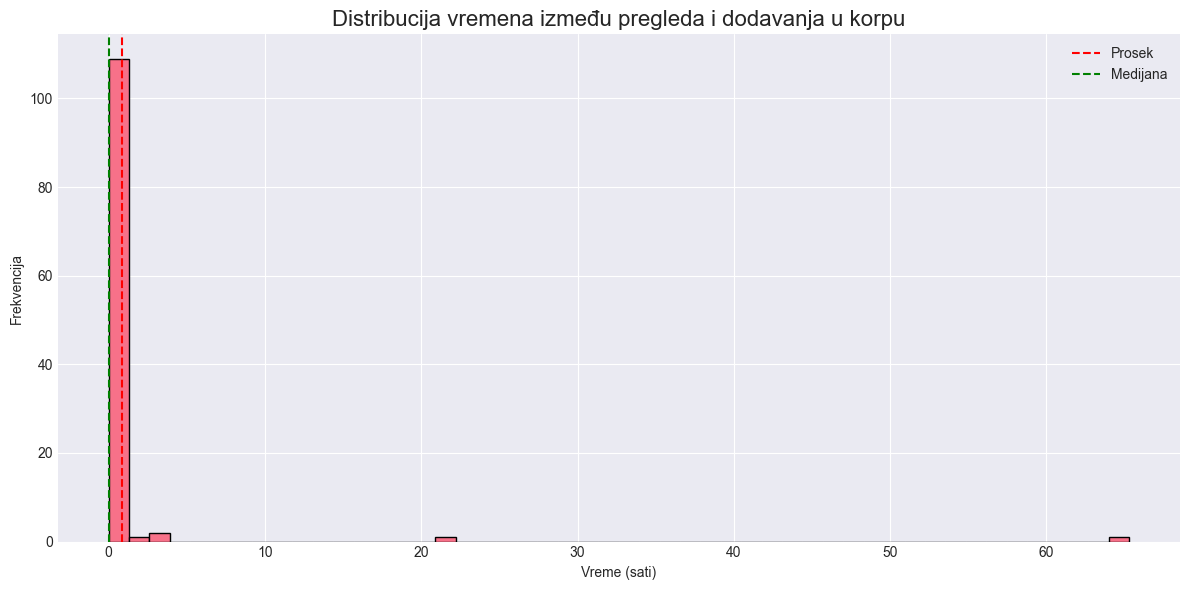


ANALIZA:
Brze konverzije (<1h): 109 (95.61%)


In [19]:
# Ova analiza zahteva složeniji aggregation
pipeline = [
    {
        "$match": {
            "action": {"$in": ["content_view", "add_to_cart"]}
        }
    },
    {
        "$sort": {"user_uid": 1, "product_id": 1, "created": 1}
    },
    {
        "$group": {
            "_id": {
                "user": "$user_uid",
                "product": "$product_id"
            },
            "interactions": {
                "$push": {
                    "action": "$action",
                    "timestamp": "$created"
                }
            }
        }
    },
    {
        "$match": {
            "interactions.1": {"$exists": True}  # Najmanje 2 interakcije
        }
    },
    {
        "$limit": 1000  # Uzorak za performanse
    }
]

result = list(db.interactions.aggregate(pipeline))

# Analiza u Python-u
time_diffs = []
for doc in result:
    interactions = doc['interactions']
    for i in range(len(interactions) - 1):
        if (interactions[i]['action'] == 'content_view' and 
            interactions[i+1]['action'] == 'add_to_cart'):
            time_diff = (interactions[i+1]['timestamp'] - interactions[i]['timestamp']) / 3600  # u satima
            if 0 < time_diff < 72:  # Razumno vremensko okno
                time_diffs.append(time_diff)

if time_diffs:
    df_time = pd.DataFrame({'time_diff_hours': time_diffs})
    
    print("\n=== Vremenska Analiza Konverzije ===")
    print(f"Analizirano konverzija: {len(time_diffs)}")
    print(f"Prosečno vreme do konverzije: {df_time['time_diff_hours'].mean():.2f} sati")
    print(f"Medijana vremena: {df_time['time_diff_hours'].median():.2f} sati")
    print(f"Standardna devijacija: {df_time['time_diff_hours'].std():.2f} sati")
    
    # Vizualizacija
    plt.figure(figsize=(12, 6))
    plt.hist(time_diffs, bins=50, edgecolor='black')
    plt.title('Distribucija vremena između pregleda i dodavanja u korpu', fontsize=16)
    plt.xlabel('Vreme (sati)')
    plt.ylabel('Frekvencija')
    plt.axvline(df_time['time_diff_hours'].mean(), color='red', linestyle='--', label='Prosek')
    plt.axvline(df_time['time_diff_hours'].median(), color='green', linestyle='--', label='Medijana')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nANALIZA:")
    quick_conversions = len([t for t in time_diffs if t < 1])
    print(f"Brze konverzije (<1h): {quick_conversions} ({(quick_conversions/len(time_diffs)*100):.2f}%)")
else:
    print("Nije pronađeno dovoljno podataka za analizu")

---

In [20]:
# Zatvori konekciju
client.close()
print("\nMongoDB konekcija zatvorena")

MongoDB connection closed

MongoDB konekcija zatvorena
